In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

### Import dataset

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
# no duplicate lines
train.duplicated().value_counts()

False    660611
dtype: int64

In [4]:
# no duplicate observation_id
train['observation_id'].duplicated().value_counts()

False    660611
Name: observation_id, dtype: int64

### Features adjustments

In [5]:
# transforming Date column in datetime
train['Date']=pd.to_datetime(train['Date'], infer_datetime_format=True)

# auxiliar Date feature (for temporal analyzis)
train['referencia'] = train['Date'].dt.year*100 + train['Date'].dt.month

# according to Dr Wilson's instructions: 
# "If there was a search and the outcome linked to object of search has not been written please consider it to be False"
train['Outcome linked to object of search'] = train['Outcome linked to object of search'].fillna(False)

# according to Dr Wilson's instructions missing values means False 
train['Part of a policing operation'] = train['Part of a policing operation'].fillna(False)

# Outer clothing be filled with False? 
#Yes, except when it’s just a vehicle search, in which case it makes no sense and should be kept as NaN
mask= ((train['Type']!='Vehicle search') & 
      (train['Removal of more than just outer clothing'] != True) &
      (train['Removal of more than just outer clothing'] != False))

train.loc[mask, 'Removal of more than just outer clothing']=False

### Filtering / Exclusions

In [6]:
# The Metropolitan station (which is very large and has lots of data in the training set) has the features 
# Outcome linked to object of search and Removal of outer clothing without any data (always missing). 
# Is this a known problem, and if so how should we proceed? 
# Thank you for bringing this to our attention, I’ve contacted the administration at the Metropolitan and asked that 
# they fix their data entry. Please include this in your report, and do not use the Metropolitan station’s data 
# for training your models. They will not be in the test set. 

In [7]:
# Gwent and Humberside have the same problem of Metropolitan. So I will exclude this observations

In [8]:
stations_to_exclude = ['metropolitan', 'gwent', 'humberside']
train_model = train[~train['station'].isin(stations_to_exclude)]
print("Exclusion of {} observations".format(train[train['station'].isin(stations_to_exclude)]['observation_id'].nunique()))
train_model.shape

Exclusion of 355849 observations


(304762, 17)

In [9]:
# Search on individuals with less than 10 years seems unrealist, so I will remove it

In [10]:
# age_to_exclude = ['under 10']
# print("Exclusion of {} observations".format(train_model[train_model['Age range'].isin(age_to_exclude)]['observation_id'].nunique()))
# train_model = train_model[~train_model['Age range'].isin(age_to_exclude)]
# train_model.shape

### Target

In [11]:
positive_outcome = ['Local resolution',
           'Community resolution',
           'Arrest',
           'Article found - Detailed outcome unavailable',
           'Caution (simple or conditional)',
           'Khat or Cannabis warning',
           'Offender cautioned',
           'Offender given drugs possession warning',
           'Offender given penalty notice',
           'Penalty Notice for Disorder',
           'Summons / charged by post',
           'Suspect arrested',
           'Suspect summonsed to court',
           'Suspected psychoactive substances seized - No further action']

train_model['positive_outcome'] = train_model['Outcome'].isin(positive_outcome)

In [12]:
train_model['target'] = 0
mask=((train_model["positive_outcome"] == True) & (train_model["Outcome linked to object of search"]==True))
train_model.loc[mask, 'target']=1

In [13]:
pd.crosstab(train_model["positive_outcome"],train_model["Outcome linked to object of search"],
            margins=True, margins_name="Total",dropna=False)

Outcome linked to object of search,False,True,Total
positive_outcome,,,
False,174918,37987,212905
True,29571,62286,91857
Total,204489,100273,304762


In [14]:
print(train_model['target'].value_counts(dropna=False))
train_model['target'].value_counts(dropna=False,normalize=True)

0    242476
1     62286
Name: target, dtype: int64


0    0.795624
1    0.204376
Name: target, dtype: float64

In [15]:
# print(train_model['positive_outcome'].value_counts(dropna=False))
# train_model['positive_outcome'].value_counts(dropna=False,normalize=True)
# pd.crosstab(train_model["referencia"],train_model["target"],normalize='index')
# pd.crosstab(train_model["Gender"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["positive_outcome"],normalize='index')

### Feature engineering

In [16]:
# get the hour and day of the week, maybe they will be useful 
train_model['hour'] = train_model['Date'].dt.hour
train_model['month'] = train_model['Date'].dt.month
train_model['day_of_week'] = train_model['Date'].dt.day_name()

In [17]:
# Legislation - reducing the quantity of categories
# train_model.groupby(['Legislation','target'], dropna=False)['Outcome'].count().unstack()

train_model['Legislation']=train_model['Legislation'].fillna('missing infomation')
train_model['Legislation'] = train_model['Legislation'].apply(lambda x: str(x).lower())

legislation_categories = ['misuse of drugs act 1971 (section 23)', 'police and criminal evidence act 1984 (section 1)', 
                          'criminal justice and public order act 1994 (section 60)', 'firearms act 1968 (section 47)',
                          'missing infomation']

mask=(~train_model['Legislation'].isin(legislation_categories))
train_model.loc[mask, 'Legislation']='others'

train_model['Legislation'].value_counts()

misuse of drugs act 1971 (section 23)                      178620
police and criminal evidence act 1984 (section 1)           92651
missing infomation                                          27931
criminal justice and public order act 1994 (section 60)      2670
firearms act 1968 (section 47)                               1830
others                                                       1060
Name: Legislation, dtype: int64

### Text Data normalization

In [18]:
train_model['Object of search'] = train_model['Object of search'].apply(lambda x: str(x).lower())
train_model['Object of search'].value_counts()

controlled drugs                              192161
offensive weapons                              35391
article for use in theft                       30287
stolen goods                                   26617
articles for use in criminal damage             6494
anything to threaten or harm anyone             5241
firearms                                        2957
evidence of offences under the act              1930
psychoactive substances                         1701
fireworks                                       1695
detailed object of search unavailable            129
game or poaching equipment                        96
goods on which duty has not been paid etc.        23
evidence of wildlife offences                     21
crossbows                                         17
seals or hunting equipment                         2
Name: Object of search, dtype: int64

In [19]:
train_model['station'] = train_model['station'].apply(lambda x: str(x).lower())
# train_model['station'].value_counts()

### Latitude and Longitude

In [20]:
print(train_model['Latitude'].describe())
train_model['Longitude'].describe()

count    228038.000000
mean         52.511589
std           1.133850
min          49.892149
25%          51.485978
50%          52.609826
75%          53.422686
max          57.143856
Name: Latitude, dtype: float64


count    228038.000000
mean         -1.343263
std           1.365160
min          -8.053397
25%          -2.599163
50%          -1.464553
75%          -0.207006
max           1.756480
Name: Longitude, dtype: float64

In [21]:
train_model['Latitude'] = train_model['Longitude'].fillna(0)
train_model['Longitude'] = train_model['Longitude'].fillna(50)

### Data split

In [22]:
df_train, df_test = train_test_split(train_model, test_size=0.3, random_state=42)

In [23]:
df_train.shape

(213333, 22)

In [24]:
df_test.shape

(91429, 22)

In [25]:
df_train.day_of_week.value_counts()

Saturday     34161
Friday       33994
Thursday     30593
Wednesday    30283
Tuesday      28674
Monday       27828
Sunday       27800
Name: day_of_week, dtype: int64

### Training a baseline model

In [26]:
all_features = ['Type', 'Part of a policing operation', 'Age range', 'Latitude', 'Longitude',
                'Legislation', 'hour', 'month', 'day_of_week',
                'Gender']

numerical_features = ['hour', 'month','Latitude', 'Longitude']

categorical_features = ['Type', 'Part of a policing operation', 'Age range',
                        'Legislation', 'day_of_week','Gender']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42, n_jobs=-1),
)


X_train = df_train[all_features]
y_train = df_train['target']

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test['target']

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
# X_train_baseline = X_train.copy()
# X_test_baseline = df_test.copy()
# y_test_baseline = X_test_baseline[target].copy()
# y_pred_baseline = y_pred.copy()
# pipeline_baseline = pipeline

roc_auc_score(y_test, y_pred)

0.5298813415417861

In [27]:
# ?RandomForestClassifier

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

In [29]:
precision = precision[:-1]
recall = recall[:-1]

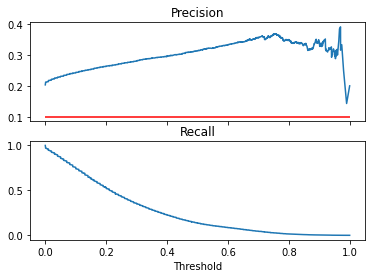

In [30]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.1,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

In [31]:
min_index = [i for i, prec in enumerate(precision) if prec > 0.27][0]
print(min_index)
thresholds[min_index]

4350


0.24004365079365064

In [32]:
precision[min_index]

0.2707609621812938

In [33]:
recall[min_index]

0.44452813945980846

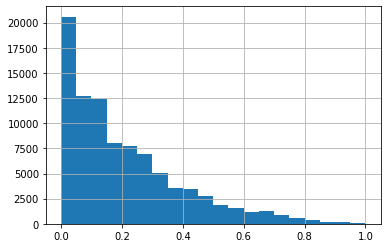

In [34]:
pd.Series(y_proba[:,1]).hist(bins=20, figsize=(6, 4));
# df.hist(column='SubjectAge', bins=20, figsize=(6, 4));

In [35]:
threshold = thresholds[min_index]
y_pred_threshold = pd.Series([True if p >= threshold else False for p in y_proba[:,1]]).to_numpy()

In [36]:
print(type(y_pred))
type(y_pred_threshold)

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.<class 'numpy.ndarray'>



numpy.ndarray

#### most important features

Feature ranking:
1. feature Longitude (0.258364)
2. feature Latitude (0.257545)
3. feature hour (0.206573)
4. feature month (0.160394)
5. feature Legislation_misuse of drugs act 1971 (section 23) (0.011799)
6. feature Legislation_police and criminal evidence act 1984 (section 1) (0.009524)
7. feature day_of_week_Saturday (0.007911)
8. feature day_of_week_Wednesday (0.007802)
9. feature day_of_week_Friday (0.007785)
10. feature day_of_week_Thursday (0.007689)


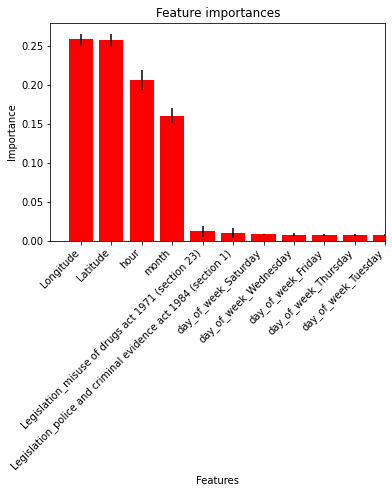

In [37]:
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
random_forest_step = pipeline.named_steps['randomforestclassifier']

onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()

## Formalizing client requirements

### 1 - Minimum 10% success rate for searches per station and search objective

In [38]:
def verify_global_success_rate(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    """
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    is_satisfied = (precision >= min_success_rate)
    
    recall = recall_score(y_true, y_pred, pos_label=1)
    
    return is_satisfied, precision, recall

In [39]:
is_verified, success_rate, recall = verify_global_success_rate(y_test, y_pred_threshold)

print("Global Precision: {}".format((is_verified, success_rate)))
print("Global Recall: {}".format(recall))

Global Precision: (True, 0.2707609621812938)
Global Recall: 0.44452813945980846


In [40]:
# exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks', 
#                  'detailed object of search unavailable','game or poaching equipment',
#                  'goods on which duty has not been paid etc.','evidence of wildlife offences',
#                  'crossbows','seals or hunting equipment']

# t=df_test['Object of search'].unique()

# for i in t:
#     if i not in exclusion_list:
#         print(i)

In [41]:
def verify_success_rate_objective_station(X_test, y_true, y_pred, sensitive_column='Object of search', 
                                          min_success_rate=0.1, min_samples=50):
    """
    Verifies that success rate per station and search objective is higher than 10%
    """
    
#     exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks', 
#                  'detailed object of search unavailable','game or poaching equipment',
#                  'goods on which duty has not been paid etc.','evidence of wildlife offences',
#                  'crossbows','seals or hunting equipment']

    exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks',
                      'detailed object of search unavailable','game or poaching equipment',
                      'goods on which duty has not been paid etc.','evidence of wildlife offences',
                      'crossbows','seals or hunting equipment',
                      'firearms','evidence of offences under the act','psychoactive substances']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_list:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            precision_min = np.min(list(precisions.values()))

            if precision_min < min_success_rate:
                is_satisfied = False
                problematic_departments.append((department, precision_min, precisions))
            else:
                good_deparments.append((department, precision_min, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            global_precisions[department] = precision_score(y_true[mask], y_pred[mask])
            
    global_precisions_objective = {}
    for obj in sensitive_classes:
        mask = (X_test[sensitive_column] == obj)
        if np.sum(mask) > min_samples:
            global_precisions_objective[obj] = precision_score(y_true[mask], y_pred[mask])
    
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions,global_precisions_objective

In [42]:
is_satisfied, problematic_departments, good_deparments, ignored_departments,global_precisions, global_precisions_objective = verify_success_rate_objective_station(df_test, y_test, y_pred_threshold, min_success_rate=0.1)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic stations: {}".format(len(problematic_departments)))
    print("Num good stations: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    print("\nObject of search rates: {}".format(global_precisions_objective))
    print("\nStation rates: {}".format(global_precisions))


Requirement failed 😢
Num problematic stations: 11
Num good stations: 26
Num ignored departments: 2

Object of search rates: {'controlled drugs': 0.2915455526949589, 'article for use in theft': 0.16878980891719744, 'stolen goods': 0.27103301384451545, 'anything to threaten or harm anyone': 0.12446351931330472, 'offensive weapons': 0.16715715126545028, 'fireworks': 0.05555555555555555, 'articles for use in criminal damage': 0.037422037422037424, 'firearms': 0.18110236220472442, 'evidence of offences under the act': 0.2076923076923077, 'psychoactive substances': 0.3275862068965517}

Station rates: {'bedfordshire': 0.268733850129199, 'hertfordshire': 0.30015197568389057, 'kent': 0.2960312296681848, 'btp': 0.305978898007034, 'warwickshire': 0.2874617737003058, 'staffordshire': 0.28991060025542786, 'leicestershire': 0.16400911161731208, 'derbyshire': 0.27009646302250806, 'cheshire': 0.35911602209944754, 'west-yorkshire': 0.22835990888382687, 'suffolk': 0.23961661341853036, 'hampshire': 0.320

In [43]:
problematic_departments

[('staffordshire',
  0.06666666666666667,
  {'controlled drugs': 0.32371794871794873,
   'article for use in theft': 0.06666666666666667,
   'stolen goods': 0.2125,
   'offensive weapons': 0.125}),
 ('leicestershire',
  0.0,
  {'controlled drugs': 0.18579234972677597,
   'article for use in theft': 0.0,
   'stolen goods': 0.07692307692307693,
   'offensive weapons': 0.03125}),
 ('suffolk',
  0.0,
  {'controlled drugs': 0.2607003891050584,
   'article for use in theft': 0.0,
   'stolen goods': 0.23529411764705882,
   'offensive weapons': 0.25}),
 ('south-yorkshire',
  0.0,
  {'controlled drugs': 0.23325062034739455,
   'article for use in theft': 0.0,
   'stolen goods': 0.0,
   'offensive weapons': 0.12987012987012986}),
 ('norfolk',
  0.0,
  {'controlled drugs': 0.18507462686567164,
   'article for use in theft': 0.0,
   'stolen goods': 0.1111111111111111,
   'offensive weapons': 0.2}),
 ('dyfed-powys',
  0.0,
  {'controlled drugs': 0.017341040462427744, 'article for use in theft': 0.0

In [44]:
good_deparments

[('bedfordshire',
  0.1111111111111111,
  {'controlled drugs': 0.29780564263322884,
   'article for use in theft': 0.15384615384615385,
   'stolen goods': 0.1111111111111111,
   'offensive weapons': 0.125}),
 ('hertfordshire',
  0.15492957746478872,
  {'controlled drugs': 0.3153409090909091,
   'article for use in theft': 0.23853211009174313,
   'stolen goods': 0.3333333333333333,
   'offensive weapons': 0.15492957746478872}),
 ('kent',
  0.16071428571428573,
  {'controlled drugs': 0.29533678756476683,
   'article for use in theft': 0.26666666666666666,
   'stolen goods': 0.35443037974683544,
   'offensive weapons': 0.16071428571428573}),
 ('btp',
  0.13114754098360656,
  {'controlled drugs': 0.31921331316187596,
   'article for use in theft': 0.19047619047619047,
   'stolen goods': 0.39080459770114945,
   'offensive weapons': 0.13114754098360656}),
 ('warwickshire',
  0.15789473684210525,
  {'controlled drugs': 0.3247863247863248,
   'article for use in theft': 0.2727272727272727,
   

In [45]:
print(min(global_precisions.values()))
max(global_precisions.values())

0.03773584905660377


0.37662337662337664

In [46]:
print(min(global_precisions_objective.values()))
max(global_precisions_objective.values())

0.037422037422037424


0.3275862068965517

In [47]:
# mask = (X_test['Object of search'] == 'offensive weapons') & (X_test['station'] == 'bedfordshire')
# np.sum(mask)
# precision_score(y_test[mask], y_pred[mask])
# y_test[mask].value_counts()
# pd.Series(y_pred[mask]).value_counts()

### 2 - No police station should have a discrepancy bigger than 5% between the search success rate between protected classes (ethnicity, gender)

In [48]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column, max_diff=0.05, min_samples=50):
    """
    Verifies that no station has discrimination in between protected classes
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions


In [49]:
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.05)

print("\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\n\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Ethnicity
Requirement failed 😢
Global rates: {'Black': 0.2857142857142857, 'White': 0.26912995687832925, 'Other': 0.27086614173228346, 'Asian': 0.26362625139043383, 'Mixed': 0.31216931216931215}
Num problematic departments: 24
Num good departments: 6
Num ignored departments: 9
avg diff: 0.10713585591592273


Gender
Requirement failed 😢
Global rates: {'Male': 0.27167400563054933, 'Female': 0.26088521050737673, 'Other': 0.3448275862068966}
Num problematic departments: 17
Num good departments: 20
Num ignored departments: 2
avg diff: 0.08366966347543703


### 3 - No police station should have a discrepancy bigger than x% between the Removal of more than just outer clothing rate between protected classes (age, ethnicity, gender)

In [50]:
def verify_removal_clothing(X_test, y_true, y_pred, sensitive_column, max_diff, min_samples=50):
    """
    Verifies that no station has discrepancy Removal of more than just outer clothing rate between 
    protected classes (age, ethnicity, gender)
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        removal_rate = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department) & (y_pred == 1)
            if np.sum(mask) > min_samples:
                removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==1))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])
                
        if len(removal_rate) > 1:    
            diff = np.max(list(removal_rate.values())) - np.min(list(removal_rate.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, removal_rate))
            else:
                good_deparments.append((department, diff, removal_rate))
        else:
            ignored_departments.append((department, None, []))
    
    global_removal_rate = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class) & (y_pred == True)
        if np.sum(mask) > min_samples:
            global_removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==True))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])
    
#     if len(precisions) > 1:    
#         diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
#         if diff > max_diff:
#             is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate


In [51]:
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Age range', 0.05)

print("\n\nAge range")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.05)

print("\n\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Gender
Requirement failed 😢
Global rates: {'Male': 0.043348011261098676, 'Female': 0.04210147535084563}
Num problematic departments: 2
Num good departments: 15
Num ignored departments: 22
avg diff: 0.09000876667003084


Age range
Requirement failed 😢
Global rates: {'10-17': 0.021696801112656466, '25-34': 0.046071473041962394, 'over 34': 0.04132082280765067, '18-24': 0.04810506566604127}
Num problematic departments: 11
Num good departments: 25
Num ignored departments: 3
avg diff: 0.07072929603176129


Ethnicity
Requirement failed 😢
Global rates: {'Black': 0.10242587601078167, 'White': 0.033947746681322395, 'Other': 0.04094488188976378, 'Asian': 0.04968483500185391, 'Mixed': 0.07407407407407407}
Num problematic departments: 10
Num good departments: 11
Num ignored departments: 18
avg diff: 0.11573071583531984
